# Luis Martins
**Student Number:** 2025053
**Programme:** HDip in Sci in Data Analytics for Business
**GitHub:** [https://github.com/CCT-Dublin/ca1-50-LuiisClaudio](https://github.com/CCT-Dublin/ca1-50-LuiisClaudio)

**Date:** October 31, 2025

---

> **Dr. Muhammad Iqbal**
>
> CCT College Dublin
>
> **Module:** Machine Learning for Business

---

## Step 1: Import Necessary Libraries

First, we import all the Python libraries we'll need for data loading, cleaning, and transformation.

In [46]:
import pandas as pd
import numpy as np

## Step 2: Load the Data

We load the `PPR-ALL.csv` file into a pandas DataFrame. It's important to set `low_memory=False` to avoid mixed-type warnings due to the size of the dataset.

In [47]:
# Define the file path
file_path = 'PPR-ALL.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)


## Step 3: Initial Data Inspection

Let's get a first look at our data to understand its structure, identify data types, and find any obvious issues like missing values.

In [48]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,NaN,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,NaN,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,NaN,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",Meath,NaN,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,NaN,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [49]:
# Get a summary of the DataFrame (data types, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748893 entries, 0 to 748892
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Date of Sale (dd/mm/yyyy)  748893 non-null  object
 1   Address                    748893 non-null  object
 2   County                     748893 non-null  object
 3   Eircode                    206320 non-null  object
 4   Price ()                  748893 non-null  object
 5   Not Full Market Price      748893 non-null  object
 6   VAT Exclusive              748893 non-null  object
 7   Description of Property    748893 non-null  object
 8   Property Size Description  52834 non-null   object
dtypes: object(9)
memory usage: 51.4+ MB


In [50]:
# Check for the number of missing values (represented as nulls or empty strings)
print("\nMissing Value Counts:")
for col in df.columns:
    # Check for standard NaN values
    null_count = df[col].isnull().sum()
    
    # Check for empty strings "" which seem to be used for missing data
    empty_string_count = (df[col] == '""').sum() + (df[col] == '').sum() + (df[col] == ' ').sum()
    
    print(f"{col}: {null_count + empty_string_count} missing values")


Missing Value Counts:
Date of Sale (dd/mm/yyyy): 0 missing values
Address: 0 missing values
County: 0 missing values
Eircode: 542573 missing values
Price (): 0 missing values
Not Full Market Price: 0 missing values
VAT Exclusive: 0 missing values
Description of Property: 0 missing values
Property Size Description: 696059 missing values


### Initial Findings:

1.  **Target Variable:** `Price (€)` is an `object` (string) type. It contains '€' and ',' characters. It must be converted to a numeric type (float) to be used as a target for regression.
2.  **Date:** `Date of Sale (dd/mm/yyyy)` is an `object`. This should be converted to a datetime object so we can extract features like `Year` and `Month`, which likely influence price.
3.  **Missing Data:**
    * `Eircode` and `Property Size Description` have a very large number of missing values (represented as empty strings `""` in the CSV snippet).
4.  **Categorical Data:** `County`, `Not Full Market Price`, `VAT Exclusive`, and `Description of Property` are all `object` types and will need to be encoded.
5.  **High Cardinality:** `Address` and `Eircode` have too many unique values to be used directly in one-hot encoding. `Address` is free-text, and `Eircode` is sparse. We will likely drop these to simplify the model.

## Step 4: Data Cleaning & Feature Engineering

In [51]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,NaN,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,NaN,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,NaN,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",Meath,NaN,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,NaN,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [52]:
# Filter the data to include only properties in County Dublin, Cork, and Galway
df = df[df['County'].isin(['Dublin', 'Cork', 'Galway'])].copy()

print(f"Number of properties in Dublin, Cork, and Galway: {df.shape[0]}")
print("\nBreakdown by county:")
print(df['County'].value_counts())

Number of properties in Dublin, Cork, and Galway: 353750

Breakdown by county:
County
Dublin    234881
Cork       82637
Galway     36232
Name: count, dtype: int64


In [53]:
# Filter the original dataframe for properties sold in 2024 and 2025
df = df[(df['Date of Sale (dd/mm/yyyy)'].str.contains('/2025'))].copy() #str.contains('/2024|/2025'))].copy()

print(f"Number of properties sold in 2025: {df.shape[0]}")
df.head()

Number of properties sold in 2025: 20497


,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
705877,02/01/2025,"11 DAVIS COURT, THOMAS DAVIS ST WEST, INCHICOR...",Dublin,D08WK61,"239,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
705879,02/01/2025,"17 STATION COURT PARK, COOLMINE, DUBLIN 15",Dublin,D15PF25,"326,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
705881,02/01/2025,"2 LOIAMORE LAWN, BANDUFF, CO CORK",Cork,T23V8Y0,"230,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
705882,02/01/2025,"219 LLANDAFF TERRACE, MERRION ROAD, DUBLIN 4",Dublin,D04X5K5,"1,050,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
705885,02/01/2025,"27 HOLLYVILLE, GRANGE, CORK",Cork,T12AWK1,"370,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


### 4.1. Clean Target Variable: `Price`

# ----------------- Limiting the amout of row to test the algo faster

In [54]:
# Create a copy to avoid SettingWithCopyWarning
data = df.head(5000).copy()

# Rename columns to be more Python-friendly (remove spaces, symbols)
data.columns = ['Date_of_Sale', 'Address', 'County', 'Eircode', 'Price', 
                  'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property', 
                  'Property_Size_Description']

# Clean the 'Price' column
data['Price'] = data['Price'].astype(str).str.replace('€', '', regex=False).str.replace(',', '', regex=False).str.replace('', '', regex=False).str.strip()
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

print("Price column cleaned and converted to numeric.")
print(data['Price'].describe())

Price column cleaned and converted to numeric.
count    5.000000e+03
mean     5.117984e+05
std      1.000292e+06
min      5.500000e+03
25%      3.089250e+05
50%      4.140969e+05
75%      5.750000e+05
max      5.715272e+07
Name: Price, dtype: float64


### 4.2. Feature Engineering: `Date_of_Sale`

In [55]:
# Convert 'Date_of_Sale' to datetime objects
data['Date_of_Sale'] = pd.to_datetime(data['Date_of_Sale'], format='%d/%m/%Y')

# Extract 'Year' and 'Month' as new features
data['Sale_Year'] = data['Date_of_Sale'].dt.year
data['Sale_Month'] = data['Date_of_Sale'].dt.month

print("New features 'Sale_Year' and 'Sale_Month' created.")
data[['Date_of_Sale', 'Sale_Year', 'Sale_Month']].head()

New features 'Sale_Year' and 'Sale_Month' created.


,Date_of_Sale,Sale_Year,Sale_Month
705877,2025-01-02,2025,1
705879,2025-01-02,2025,1
705881,2025-01-02,2025,1
705882,2025-01-02,2025,1
705885,2025-01-02,2025,1


### 4.3. Handle Other Categorical Features & Missing Values

We will clean up the string values and fill missing values (`""`) with a consistent 'Unknown' category. This prepares them for one-hot encoding.

In [56]:
# Clean and impute 'Description_of_Property'
# Replace empty/whitespace strings with 'Unknown'
data['Description_of_Property'] = data['Description_of_Property'].replace(['""', '', ' '], 'Unknown')
# Fill standard NaNs with 'Unknown' as well
data['Description_of_Property'] = data['Description_of_Property'].fillna('Unknown')
# There are two variations of 'New Dwelling...' in the data, let's standardize them.
data['Description_of_Property'] = data['Description_of_Property'].replace({
    'New Dwelling house /Apartment': 'New Dwelling',
    'Second-Hand Dwelling house /Apartment': 'Second-Hand Dwelling',
    'Teach/Árasán Cónaithe Nua': 'New Dwelling',
    'Teach/?ras?n C?naithe Nua': 'New Dwelling',
    'Teach/Árasán Cónaithe Atháimhe': 'Second-Hand Dwelling'
})


# Clean and impute 'County'
data['County'] = data['County'].fillna('Unknown')

print("Categorical columns cleaned and missing values imputed with 'Unknown'.")
print("\nUnique values in 'Description_of_Property':")
print(data['Description_of_Property'].value_counts())

Categorical columns cleaned and missing values imputed with 'Unknown'.

Unique values in 'Description_of_Property':
Description_of_Property
Second-Hand Dwelling    4147
New Dwelling             853
Name: count, dtype: int64


### 4.4. Clean Binary Categorical Features

We'll convert the 'Yes'/'No' columns to integers (1/0).

In [57]:
data['Not_Full_Market_Price'] = data['Not_Full_Market_Price'].map({'Yes': 1, 'No': 0})
data['VAT_Exclusive'] = data['VAT_Exclusive'].map({'Yes': 1, 'No': 0})
data['Description_of_Property'] = data['Description_of_Property'].map({'New Dwelling': 1, 'Second-Hand Dwelling': 0})

print("Binary columns 'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property' mapped to 1/0.")
data[['Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property']].head()

Binary columns 'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property' mapped to 1/0.


,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property
705877,0,0,0
705879,0,0,0
705881,0,0,0
705882,0,0,0
705885,0,0,0


### 4.5. Feature Selection: Dropping Unused Columns

In [58]:
columns_to_drop = ['Date_of_Sale', 'Address', 'Eircode', 'Property_Size_Description']
data_cleaned = data.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print("\nCleaned data head:")
data_cleaned.head()

Dropped columns: ['Date_of_Sale', 'Address', 'Eircode', 'Property_Size_Description']

Cleaned data head:


,County,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month
705877,Dublin,239000.0,0,0,0,2025,1
705879,Dublin,326000.0,0,0,0,2025,1
705881,Cork,230000.0,0,0,0,2025,1
705882,Dublin,1050000.0,0,0,0,2025,1
705885,Cork,370000.0,0,0,0,2025,1


### 4.6. Filter 'Not Full Market Price'

For a price prediction model, sales that were **not** at full market price could skew the results. We should filter these out to train the model on representative data.

In [59]:
original_rows = data_cleaned.shape[0]
data_final = data_cleaned[data_cleaned['Not_Full_Market_Price'] == 0].copy()


# Now that we've filtered, we can drop this column as it's no longer needed as a feature.
data_final = data_final.drop(columns=['Not_Full_Market_Price'])

data_final.head()

,County,Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month
705877,Dublin,239000.0,0,0,2025,1
705879,Dublin,326000.0,0,0,2025,1
705881,Cork,230000.0,0,0,2025,1
705882,Dublin,1050000.0,0,0,2025,1
705885,Cork,370000.0,0,0,2025,1


# Handle categorical data

In [60]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'County' column using LabelEncoder
label_encoder = LabelEncoder()
data_final['County_Encoded'] = label_encoder.fit_transform(data_final['County'])

# Drop the original 'County' column as we now have the encoded version
data_final = data_final.drop(columns=['County'])

# Show the final cleaned and encoded data
print(data_final.head(10))

# Show the mapping of counties to encoded values
county_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nCounty to Encoded Value Mapping:")
for county, encoded_value in sorted(county_mapping.items(), key=lambda x: x[1]):
    print(f"{county}: {encoded_value}")

            Price  VAT_Exclusive  Description_of_Property  Sale_Year  \
705877   239000.0              0                        0       2025   
705879   326000.0              0                        0       2025   
705881   230000.0              0                        0       2025   
705882  1050000.0              0                        0       2025   
705885   370000.0              0                        0       2025   
705886   395000.0              0                        0       2025   
705888   340000.0              0                        0       2025   
705892   275000.0              0                        0       2025   
705894  1480000.0              0                        0       2025   
705902   720000.0              0                        0       2025   

        Sale_Month  County_Encoded  
705877           1               1  
705879           1               1  
705881           1               0  
705882           1               1  
705885           1    

## Define Features (X) and Target (y)

We separate our cleaned dataset into `X` (the features, or inputs) and `y` (the target, or output) which is the `Price`.

In [61]:
X = data_final.drop(columns=['Price'])
y = data_final['Price']

print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")

Features shape (X): (4752, 5)
Target shape (y): (4752,)


In [62]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data to create a validation set (80% train, 20% validation of the training data)
# This gives us approximately 64% train, 16% validation, 20% test of the original data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Data split into Train, Validation, and Test sets:")
print(f"Training set - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set - X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set - X_test: {X_test.shape}, y_test: {y_test.shape}")


# Ensure all sets have the same columns (important after one-hot encoding)
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("\nAfter one-hot encoding:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Data split into Train, Validation, and Test sets:
Training set - X_train: (3040, 5), y_train: (3040,)
Validation set - X_val: (761, 5), y_val: (761,)
Test set - X_test: (951, 5), y_test: (951,)

After one-hot encoding:
X_train shape: (3040, 5)
X_val shape: (761, 5)
X_test shape: (951, 5)


In [63]:
from sklearn.preprocessing import StandardScaler
# Use the one-hot encoded training features created earlier
X = X_train.copy()

# Scale features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Algo

## Why K-Means Clustering is Suitable for Property Segmentation

### The Problem: Identifying Groups of Highly Similar Records

K-Means is particularly suitable for our property sales data because it directly solves the objective of **maximizing segment homogeneity**:

#### **Unsupervised Learning**
K-Means is an unsupervised algorithm used when labels (pre-defined segments) are unknown, requiring the model to find its own patterns in the data. In our case, we don't have pre-labeled property segments, so k-Means discovers natural groupings based on features like price, location (county), VAT status, property type, and sale timing.

#### **Maximizing Homogeneity**
The algorithm's core function is to segment records and maximize homogeneity in the resulting subgroups. This means that property sales records grouped into one cluster (e.g., "High-Value Residential Dublin") will be highly similar to one another, while simultaneously being dissimilar to records in other clusters (e.g., "Low-Value Commercial Cork").

#### **Baseline Effectiveness**
K-Means is effective at finding clusters in data and serves as an excellent foundational model, providing a baseline for comparison with other clustering algorithms like DBSCAN and Fuzzy C-Means.

### Addressing the Need for Parameters

A critical component of implementing k-Means is justifying the choice of k. We employ two complementary methods:

#### **The Elbow Method**


#### **The Silhouette Coefficient**


#### **Davies-Bouldin Index**


By using these methods systematically, we can determine the optimal number of segments in our property data before finalizing the k-Means solution, ensuring that our clustering model provides meaningful and actionable business insights.

In [73]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

# K-means clustering evaluation metrics

ks = range(2, 25)  # evaluate k from 2 to 24
inertias = []
sil_scores = []
db_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# Print results
print("k\tInertia\t\tSilhouette\tDavies-Bouldin")
for k, i, s, d in zip(ks, inertias, sil_scores, db_scores):
    print(f"{k}\t{int(i):10d}\t{s:0.4f}\t\t{d:0.4f}")

# Select best k by each metric
best_k_sil = ks[int(np.argmax(sil_scores))]
best_k_db = ks[int(np.argmin(db_scores))]
print(f"\nBest k by silhouette score: {best_k_sil} (score={max(sil_scores):0.4f})")
print(f"Best k by Davies-Bouldin index: {best_k_db} (index={min(db_scores):0.4f})")



c:\Users\junio\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k	Inertia		Silhouette	Davies-Bouldin
2	      6064	0.5989		0.6837
3	      4217	0.4792		0.8522
4	      2848	0.5819		0.6829
5	      2324	0.6384		0.6403
6	      1893	0.6866		0.5637
7	      1394	0.7339		0.6178
8	      1008	0.8143		0.5028
9	       742	0.8318		0.4676
10	       589	0.8816		0.4074
11	       427	0.9058		0.3674
12	       317	0.9153		0.3464
13	       222	0.9407		0.3218
14	       156	0.9628		0.2378
15	        98	0.9750		0.2038
16	        50	0.9914		0.1528
17	        23	0.9952		0.3658
18	        13	0.9970		0.3593
19	         8	0.9989		0.3489
20	         3	0.9990		0.2790
21	         0	0.9992		0.2019
22	         0	0.9990		0.0000
23	         0	0.9990		0.0000
24	         0	0.9990		0.0000

Best k by silhouette score: 21 (score=0.9992)
Best k by Davies-Bouldin index: 22 (index=0.0000)


c:\Users\junio\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


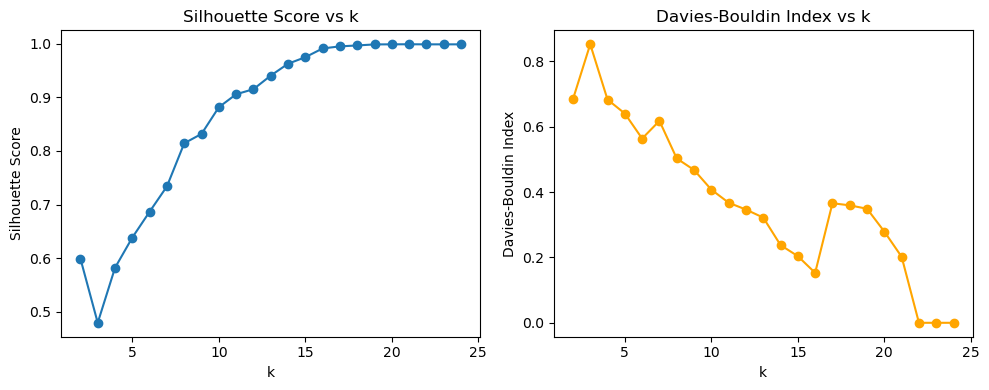


Cluster sizes for final model (chosen by silhouette):
Cluster 0: 43 samples
Cluster 1: 595 samples
Cluster 2: 693 samples
Cluster 3: 107 samples
Cluster 4: 152 samples
Cluster 5: 96 samples
Cluster 6: 425 samples
Cluster 7: 193 samples
Cluster 8: 107 samples
Cluster 9: 220 samples
Cluster 10: 86 samples
Cluster 11: 107 samples
Cluster 12: 74 samples
Cluster 13: 61 samples
Cluster 14: 51 samples
Cluster 15: 16 samples
Cluster 16: 2 samples
Cluster 17: 5 samples
Cluster 18: 4 samples
Cluster 19: 1 samples
Cluster 20: 2 samples


In [65]:
# Plot the metrics
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')

plt.subplot(1,2,2)
plt.plot(ks, db_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index vs k')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.tight_layout()
plt.show()

# Fit final model for the silhouette-optimal k and show cluster sizes
final_k = best_k_sil
final_km = KMeans(n_clusters=final_k, random_state=42, n_init=10).fit(X_scaled)
final_labels = final_km.labels_
(unique, counts) = np.unique(final_labels, return_counts=True)
print("\nCluster sizes for final model (chosen by silhouette):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

Discussion:
- Silhouette score measures how similar an object is to its own cluster compared to other clusters.
  It ranges from -1 to 1; higher is better. It considers cohesion and separation at the sample level,
  so it is sensitive to cluster shape and works well when clusters are reasonably convex and balanced.

- Davies-Bouldin index (DB) is the average similarity between each cluster and its most similar one,
  where similarity is a ratio of within-cluster scatter to between-cluster separation. Lower DB is better.
  DB is scale-dependent on intra-cluster dispersion and can favor compact, well-separated clusters.

In practice:
- Use silhouette when you want an interpretable per-sample measure of cluster quality (higher is better).
- Use Davies-Bouldin when you want a single score emphasizing compactness relative to separation (lower is better).
- They can disagree; examine cluster sizes, centroids, and, if possible, domain relevance to choose k.

## Choosing DBSCAN 

(Density-Based Spatial Clustering of Applications with Noise) for your property dataset (County, Price, VAT_Exclusive, etc.) offers distinct advantages over traditional partitioning methods like k-Means, specifically because of the unique challenges inherent in analyzing real estate market data.

**Real-world sales data often contains anomalies (outliers).** DBSCAN is excellent because it explicitly handles noise (isolated points) by assigning them to a special cluster of outliers. This is crucial for identifying potentially fraudulent or highly unusual property sales.



DBSCAN is a powerful choice because it explicitly addresses the presence of anomalies (outliers) and the formation of non-spherical clusters, both of which are common in "Housing and zoning" data.

---

### 1. Suitability: Why DBSCAN is Ideal for Property Data

DBSCAN is a density-based approach that is highly suitable because it focuses on the local density of points, enabling it to solve key segmentation problems that arise in complex market analyses:

#### A. Automatic Handling of Noise and Anomalies

Property sales data, especially price and VAT details, frequently contain outliers (e.g., highly unusual or potentially fraudulent transactions). DBSCAN is uniquely structured to handle these:

- **Outlier Identification:** Points that are isolated and too far from any other point are automatically assigned to a special cluster of outliers, designated as Noise.
- **Problem Solved:** This capability, known as Anomaly Detection, is critical in real estate analysis. By explicitly classifying these isolated records as noise, the algorithm allows you to separate highly unusual property sales (which might otherwise skew a k-Means centroid) from the standard market segments.

#### B. Discovery of Arbitrary Cluster Shapes

Market segments are often defined by geography (County) and non-linear patterns in price or property type (Description_of_Property). These clusters may not conform to the spherical shape assumed by centroid-based algorithms like k-Means.

- **Shape Flexibility:** Since clusters emerge locally by looking for neighboring points, DBSCAN can detect clusters of various shapes. This is ideal for identifying complex market segments, such as a winding high-value housing area or segmented pricing brackets that are not simple, compact groupings.
- **Mechanism:** The algorithm works bottom-up by picking a point and searching for more points within a given distance (ϵ). It then expands the cluster by repeating this process for new points until the cluster cannot be further expanded.

#### C. No Need for Pre-specifying the Number of Clusters (k)

Unlike partitioning methods that require the number of clusters (k) to be set beforehand, DBSCAN extracts clusters based purely on density.

- **Exploratory Power:** DBSCAN does not require the number of clusters to be set in advance. This makes it excellent for initial exploratory segmentation of the housing market where the natural number of segments might be unknown.

---

By selecting DBSCAN, you are leveraging an approach that is specifically designed to work well with data exhibiting varying densities and complex structures, offering deep insights into the natural boundaries and potential anomalies within your property sales market.

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

import matplotlib.pyplot as plt

# DBSCAN clustering with different parameter combinations
# We'll test different eps and min_samples values

# Use the scaled features from previous cell
X_scaled_dbscan = X_scaled

# Test different eps values (distance threshold)
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 15, 20]

results = []

print("DBSCAN Parameter Tuning Results:")
print("="*80)
print(f"{'eps':<8}{'min_samples':<15}{'n_clusters':<15}{'n_noise':<12}{'Silhouette':<15}{'Davies-Bouldin'}")
print("="*80)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled_dbscan)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only compute metrics if we have at least 2 clusters and not all points are noise
        if n_clusters >= 2 and n_noise < len(labels):
            # Exclude noise points (label -1) for metric calculation
            mask = labels != -1
            if sum(mask) > 0:
                sil_score = silhouette_score(X_scaled_dbscan[mask], labels[mask])
                db_score = davies_bouldin_score(X_scaled_dbscan[mask], labels[mask])
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': sil_score,
                    'davies_bouldin': db_score
                })
                print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{sil_score:<15.4f}{db_score:.4f}")
            else:
                print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{'N/A':<15}{'N/A'}")
        else:
            print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{'N/A':<15}{'N/A'}")

# Find best parameters by silhouette score and Davies-Bouldin index
if results:
    best_sil = max(results, key=lambda x: x['silhouette'])
    best_db = min(results, key=lambda x: x['davies_bouldin'])
    
    print("\n" + "="*80)
    print(f"Best by Silhouette Score: eps={best_sil['eps']}, min_samples={best_sil['min_samples']}")
    print(f"  Clusters: {best_sil['n_clusters']}, Noise: {best_sil['n_noise']}, Score: {best_sil['silhouette']:.4f}")
    print(f"\nBest by Davies-Bouldin Index: eps={best_db['eps']}, min_samples={best_db['min_samples']}")
    print(f"  Clusters: {best_db['n_clusters']}, Noise: {best_db['n_noise']}, Index: {best_db['davies_bouldin']:.4f}")
    
    # Fit final DBSCAN model with best silhouette parameters
    final_dbscan = DBSCAN(eps=best_sil['eps'], min_samples=best_sil['min_samples'])
    final_labels = final_dbscan.fit_predict(X_scaled_dbscan)
    
    # Show cluster distribution
    unique, counts = np.unique(final_labels, return_counts=True)
    print("\nFinal DBSCAN Cluster Distribution (best silhouette parameters):")
    for u, c in zip(unique, counts):
        if u == -1:
            print(f"Noise: {c} samples")
        else:
            print(f"Cluster {u}: {c} samples")

DBSCAN Parameter Tuning Results:
eps     min_samples    n_clusters     n_noise     Silhouette     Davies-Bouldin
0.5     5              17             9           1.0000         0.0000
0.5     10             16             14          1.0000         0.0000
0.5     15             16             14          1.0000         0.0000
0.5     20             15             30          1.0000         0.0000
1.0     5              17             9           1.0000         0.0000
1.0     10             16             14          1.0000         0.0000
1.0     15             16             14          1.0000         0.0000
1.0     20             15             30          1.0000         0.0000
1.5     5              6              5           0.5214         0.8663
1.5     10             6              5           0.5214         0.8663
1.5     15             6              5           0.5214         0.8663
1.5     20             6              5           0.5214         0.8663
2.0     5              

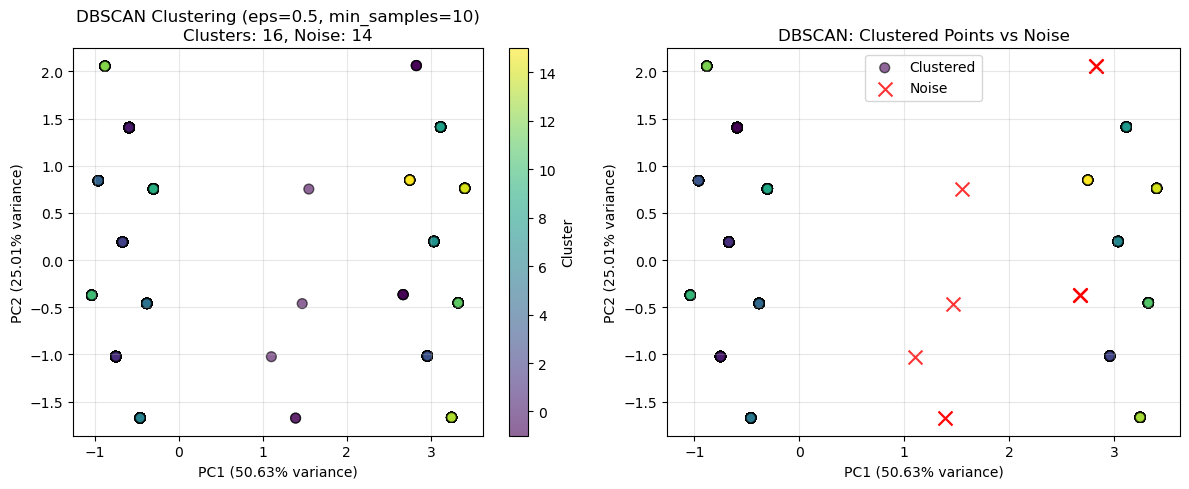


PCA explained variance ratio: [0.50630641 0.25006387]
Total variance explained: 75.64%


In [67]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_dbscan)

# Create visualization for DBSCAN clusters
plt.figure(figsize=(12, 5))

# Plot 1: DBSCAN clusters with best silhouette parameters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis', 
                     alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering (eps={best_sil["eps"]}, min_samples={best_sil["min_samples"]})\n'
          f'Clusters: {best_sil["n_clusters"]}, Noise: {best_sil["n_noise"]}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)

# Plot 2: Highlight noise points
plt.subplot(1, 2, 2)
noise_mask = final_labels == -1
plt.scatter(X_pca[~noise_mask, 0], X_pca[~noise_mask, 1], 
           c=final_labels[~noise_mask], cmap='viridis', 
           alpha=0.6, edgecolors='k', s=50, label='Clustered')
plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
           c='red', marker='x', s=100, label='Noise', alpha=0.8)
plt.title('DBSCAN: Clustered Points vs Noise')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Why Fuzzy C-Means is Ideal for Property Market Segmentation


This could be valuable if you believe certain properties might logically belong to multiple segments (e.g., a commercial property that also functions as a residential unit, or properties that sit on the boundary between "high price" and "mid price" segments).

That is a wonderful choice for an exploratory clustering method! Selecting Fuzzy C-Means (FCM) for a property dataset like yours which includes price, location, and property type is particularly insightful because it allows you to capture the inherent ambiguity and overlap found in real estate markets.

Here is why you should consider Fuzzy C-Means, how it is suitable for your segmentation problem, and the unique problem it solves:

---

### 1. Core Suitability: Handling Overlapping Market Segments

Fuzzy C-Means (FCM) is most suitable for your dataset when you believe that market boundaries are not absolute and that certain properties logically share characteristics of multiple segments. This addresses the challenge of making rigid segmentation decisions in a complex domain like Housing and Zoning.

#### The Problem FCM Solves: Ambiguity and Shared Membership

Unlike conventional (non-fuzzy or hard) clustering algorithms, such as k-Means, which assign each object to a single cluster (giving values of either 0 or 1, or true or false), FCM operates under the principle of fuzzy logic.

**FCM solves the problem of rigid partitioning by allowing data elements to belong to more than one cluster simultaneously.**

1. **Nuanced Categorization:** With FCM, each property record is associated with a set of membership levels. These membership levels are values between 0 and 1, which represent the extent to which each property is a member of each cluster.

2. **Quantifying Overlap:** The sum of the membership values for each item across all clusters always equals 1. This allows the analysis to quantify exactly how much a property belongs to one segment versus another.
    - **Example:** If a property sale (Price, Description_of_Property) sits exactly on the borderline between "Luxury Residential" and "High-Value Commercial," FCM might assign it a membership of 0.6 to the first cluster and 0.4 to the second, providing richer, more descriptive segments than a hard assignment (1.0 to one, 0.0 to the other).

---


### Conclusion

By implementing FCM, you are choosing an algorithm that respects the subtle shades of grey in market segmentation, offering a more realistic view of how properties might influence or belong to multiple market segments simultaneously.

In [70]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Fuzzy C-Means Implementation
import matplotlib.pyplot as plt

class FuzzyCMeans:
    def __init__(self, n_clusters=3, m=2, max_iter=100, error=1e-5, random_state=42):
        self.n_clusters = n_clusters
        self.m = m  # fuzziness parameter
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state
        
    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Initialize membership matrix randomly
        self.u = np.random.dirichlet(np.ones(self.n_clusters), size=n_samples)
        
        for iteration in range(self.max_iter):
            u_old = self.u.copy()
            
            # Update cluster centers
            um = self.u ** self.m
            self.centers = (X.T @ um / np.sum(um, axis=0)).T
            
            # Update membership matrix
            distances = np.zeros((n_samples, self.n_clusters))
            for i in range(self.n_clusters):
                distances[:, i] = np.linalg.norm(X - self.centers[i], axis=1)
            
            # Avoid division by zero
            distances = np.fmax(distances, np.finfo(np.float64).eps)
            
            for i in range(self.n_clusters):
                self.u[:, i] = 1.0 / np.sum((distances[:, i][:, None] / distances) ** (2 / (self.m - 1)), axis=1)
            
            # Check convergence
            if np.linalg.norm(self.u - u_old) < self.error:
                break
                
        return self
    
    def predict(self, X):
        # Return hard clustering (highest membership)
        return np.argmax(self.u, axis=1)

# Fuzzy C-Means clustering evaluation
print("="*80)
print("FUZZY C-MEANS CLUSTERING EVALUATION")
print("="*80)

# Use the same scaled data
X_scaled_fcm = X_scaled.copy()

c_values = range(2, 25)  # number of clusters
fcm_inertias = []
fcm_sil_scores = []
fcm_db_scores = []

for c in c_values:
    fcm = FuzzyCMeans(n_clusters=c, m=2, random_state=42)
    fcm.fit(X_scaled_fcm)
    labels = fcm.predict(X_scaled_fcm)
    
    # Calculate metrics
    fcm_sil_scores.append(silhouette_score(X_scaled_fcm, labels))
    fcm_db_scores.append(davies_bouldin_score(X_scaled_fcm, labels))

# Print results
print("\nc\tSilhouette\tDavies-Bouldin")
for c, s, d in zip(c_values, fcm_sil_scores, fcm_db_scores):
    print(f"{c}\t{s:0.4f}\t\t{d:0.4f}")

# Select best c by each metric
best_c_sil = c_values[int(np.argmax(fcm_sil_scores))]
best_c_db = c_values[int(np.argmin(fcm_db_scores))]
print(f"\nBest c by silhouette score: {best_c_sil} (score={max(fcm_sil_scores):0.4f})")
print(f"Best c by Davies-Bouldin index: {best_c_db} (index={min(fcm_db_scores):0.4f})")

# Fit final FCM model
final_fcm = FuzzyCMeans(n_clusters=best_c_sil, m=2, random_state=42)
final_fcm.fit(X_scaled_fcm)
final_fcm_labels = final_fcm.predict(X_scaled_fcm)

# Show cluster distribution
unique, counts = np.unique(final_fcm_labels, return_counts=True)
print("\nFuzzy C-Means Cluster Distribution (best silhouette parameters):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

FUZZY C-MEANS CLUSTERING EVALUATION

c	Silhouette	Davies-Bouldin
2	0.5988		0.6850
3	0.4793		0.8521
4	0.5819		0.6829
5	0.5720		0.7906
6	0.7601		0.4656
7	0.7145		0.6364
8	0.7621		0.5340
9	0.8245		0.4669
10	0.8816		0.4074
11	0.9017		0.3720
12	0.9147		0.3592
13	0.9361		0.3293
14	0.9628		0.2378
15	0.9789		0.1821
16	0.9914		0.1528
17	0.9931		0.1376
18	0.9970		0.3593
19	0.9989		0.3489
20	0.9969		0.2261
21	0.9986		0.2630
22	0.9990		0.0000
23	0.9990		0.0000
24	0.9990		0.0000

Best c by silhouette score: 22 (score=0.9990)
Best c by Davies-Bouldin index: 23 (index=0.0000)

Fuzzy C-Means Cluster Distribution (best silhouette parameters):
Cluster 0: 74 samples
Cluster 1: 693 samples
Cluster 2: 425 samples
Cluster 3: 2 samples
Cluster 4: 43 samples
Cluster 5: 107 samples
Cluster 6: 220 samples
Cluster 7: 152 samples
Cluster 8: 5 samples
Cluster 9: 1 samples
Cluster 10: 193 samples
Cluster 11: 1 samples
Cluster 12: 107 samples
Cluster 13: 16 samples
Cluster 14: 595 samples
Cluster 15: 51 samples
Clus

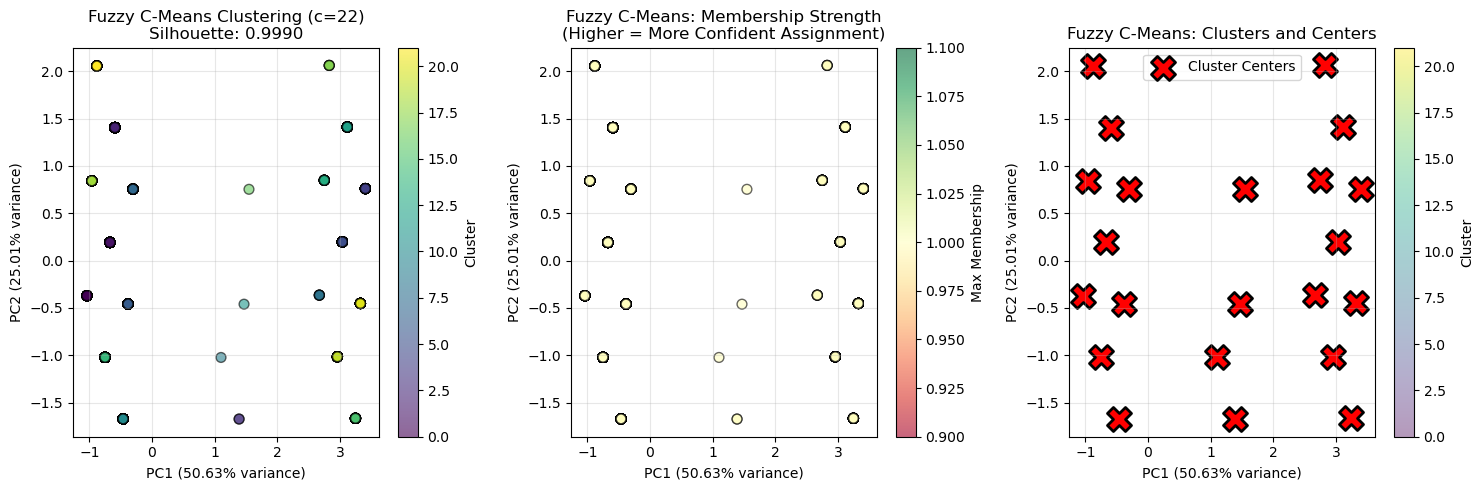

In [71]:
# Visualize Fuzzy C-Means clustering results
plt.figure(figsize=(15, 5))

# Perform PCA for visualization if not already done for FCM
X_pca_fcm = X_pca  # Reuse the PCA transformation from earlier

# Plot 1: FCM clusters in PCA space
plt.subplot(1, 3, 1)
scatter1 = plt.scatter(X_pca_fcm[:, 0], X_pca_fcm[:, 1], c=final_fcm_labels, 
                       cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter1, label='Cluster')
plt.title(f'Fuzzy C-Means Clustering (c={best_c_sil})\n'
          f'Silhouette: {max(fcm_sil_scores):.4f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)

# Plot 2: Membership strength visualization (max membership value per point)
plt.subplot(1, 3, 2)
max_membership = np.max(final_fcm.u, axis=1)
scatter2 = plt.scatter(X_pca_fcm[:, 0], X_pca_fcm[:, 1], c=max_membership, 
                       cmap='RdYlGn', alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter2, label='Max Membership')
plt.title('Fuzzy C-Means: Membership Strength\n(Higher = More Confident Assignment)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)

# Plot 3: Cluster centers in PCA space
plt.subplot(1, 3, 3)
scatter3 = plt.scatter(X_pca_fcm[:, 0], X_pca_fcm[:, 1], c=final_fcm_labels, 
                       cmap='viridis', alpha=0.4, edgecolors='k', s=30)
# Transform cluster centers to PCA space
centers_pca = pca.transform(final_fcm.centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidths=2, label='Cluster Centers')
plt.colorbar(scatter3, label='Cluster')
plt.title('Fuzzy C-Means: Clusters and Centers')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()